In [ ]:
%matplotlib inline

                          TRÁFICO WEB DE RED                    
Autor: Ana Ndongo
Fecha: 20/10/2024   
dataSet:  https://www.kaggle.com/datasets/rudrakumar96/web-firewall-good-and-bad-request
Variable objetivo: class
          
#####################################################################################
 Sobre el Conjunto de Datos
 Este conjunto de datos contiene registros de tráfico de red capturados con
 Burp-Suite, orientados a clasificar las solicitudes web como buenas o malas
 según sus características. El conjunto de datos está diseñado para la tarea de
 predecir si las solicitudes entrantes son legítimas (buenas) o maliciosas (malas),
 ayudando en la detección y prevención de ataques basados en la web.

 --- Resumen de los pasos realizados ---

1. Cargar el archivo CSV original.
2. Eliminar columnas irrelevantes.
3. Imputar valores nulos en body con "EMPTY".
4. Crear nuevas columnas con recuentos de palabras clave sospechosas.
5. Análisis exploratorio#
6. Identificar outliers con boxplots.
7. Calcular correlaciones con la variable objetivo class.
8. Balanceo de clases#
9. Aplicar SMOTE en el conjunto de entrenamiento para equilibrar clases.
10. Entrenamiento de modelos#
11. Probar múltiples algoritmos de clasificación:
12. Regresión Logística, KNN, Naive Bayes, Árbol de Decisión, Random Forest y XGBoost.
13. Evaluación de modelos#
14. Calcular métricas (Accuracy, Recall, F1, ROC-AUC).
15. Graficar matrices de confusión para comparar el desempeño.
16. Validación cruzada#
17. Comparar modelos con validación cruzada y LazyClassifier.
#####################################################################################

In [1]:
!pip install lazypredict

El dataset tiene 16 columnas y 522 filas

In [7]:

# --- 1. IMPORTACIÓN DE LIBRERÍAS ---
import os
import pandas as pd
import re
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
from lazypredict.Supervised import LazyClassifier
from imblearn.over_sampling import SMOTE

# --- 2. CARGA Y EXPLORACIÓN DE DATOS ---
print("\n--- CARGA Y EXPLORACIÓN ---")
# Ruta al dataset
data_path = r"/content/sample_data"
os.chdir(data_path)
df = pd.read_csv("all_datas_f.csv")

# ----- Información general

df.shape # Dimensiones del dataset
df.info()# Tipos de datos y estructura:


--- CARGA Y EXPLORACIÓN ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 522 entries, 0 to 521
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   method          522 non-null    object
 1   path            522 non-null    object
 2   body            104 non-null    object
 3   single_q        522 non-null    int64 
 4   double_q        522 non-null    int64 
 5   dashes          522 non-null    int64 
 6   braces          522 non-null    int64 
 7   spaces          522 non-null    int64 
 8   percentages     522 non-null    int64 
 9   semicolons      522 non-null    int64 
 10  angle_brackets  522 non-null    int64 
 11  special_chars   522 non-null    int64 
 12  path_length     522 non-null    int64 
 13  body_length     522 non-null    int64 
 14  badwords_count  522 non-null    int64 
 15  class           522 non-null    int64 
dtypes: int64(13), object(3)
memory usage: 65.4+ KB


El data set contiene datos categóricos y numéricos

In [8]:
# Visualización de las primeras y últimas filas:
df.head()
df.tail()

,method,path,body,single_q,double_q,dashes,braces,spaces,percentages,semicolons,angle_brackets,special_chars,path_length,body_length,badwords_count,class
517,GET,/static/index.jsp?content=%3Cxsl%3Avalue-of+se...,NaN,2,2,0,1,1,0,0,2,0,80,0,2,1
518,GET,/search.jsp?query=system-property%28%27xsl%3Av...,NaN,2,0,0,1,0,0,0,1,0,49,0,1,1
519,POST,/doLogin,uid=%3Cxsl%3Avariable+name%3D%22rtobject%22+se...,2,14,0,3,7,0,0,8,0,8,275,6,1
520,GET,/ws_ftp.ini,NaN,0,0,0,0,0,0,0,0,0,11,0,0,1
521,POST,/doSubscribe,txtEmail=%3Cxsl%3Avariable+name%3D%22rtobject%...,2,14,0,3,7,0,0,8,0,12,274,5,1


 Para las categóricas se observa que para estas tres columnas
se destaca que efectivamente, body tiene valores nulos, y que hay un porcentaje alto de valores únicos,
el método GET es más frecuente de los dos valores únicos que hay, y el valor más repetido es la petición /sendFeedback

In [9]:
# ----- Análisis descriptivo

df.describe() # Estadísticas para columnas numéricas:
df.describe(include=['object'])# Estadísticas para columnas categóricas:

,method,path,body
count,522,522,104
unique,2,228,78
top,GET,/sendFeedback,"<?php exec('echo it6f7t1r2rx7ymxrs5fx',$colm);..."
freq,418,36,16


 Solo hay valores NaN en la columna de "body", concretamente el 80% de dicha columna

In [10]:
# ----- Valores nulos y duplicados

# Número y proporción de valores nulos por columna:
df.isnull().sum()
df.isnull().mean()

,0
method,0.00
path,0.00
body,0.80
single_q,0.00
double_q,0.00
dashes,0.00
braces,0.00
spaces,0.00
percentages,0.00
semicolons,0.00


El valor de la duplicidad es por valores numéricos en los campos, no por filas o columnas
se descarta que hayan filas o columnas duplicadas

In [11]:
df[df.isnull().any(axis=1)] # Filas con valores nulos:

# Detección de filas duplicadas:
df.duplicated().sum()
df[df.duplicated()]

,method,path,body,single_q,double_q,dashes,braces,spaces,percentages,semicolons,angle_brackets,special_chars,path_length,body_length,badwords_count,class
253,GET,/index.jsp?content=privacy.htm,NaN,0,0,0,0,0,0,0,0,0,30,0,0,0
254,GET,/login.jsp,NaN,0,0,0,0,0,0,0,0,0,10,0,0,0
255,GET,/login.jsp,NaN,0,0,0,0,0,0,0,0,0,10,0,0,0
256,GET,/index.jsp?content=inside_contact.htm,NaN,0,0,0,0,0,0,0,0,0,37,0,0,0
258,GET,/index.jsp?content=inside_contact.htm,NaN,0,0,0,0,0,0,0,0,0,37,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,GET,/index.jsp?content=business_insurance.htm,NaN,0,0,0,0,0,0,0,0,0,41,0,0,0
496,GET,/index.jsp?content=business_insurance.htm,NaN,0,0,0,0,0,0,0,0,0,41,0,0,0
497,GET,/index.jsp?content=business_deposit.htm,NaN,0,0,0,0,0,0,0,0,0,39,0,0,0
498,GET,/high_yield_investments.htm,NaN,0,0,0,0,0,0,0,0,0,27,0,0,0


Analizo la información de las columnas categoricas:
- method: Hay más solicitudes GET que POST en este dataSet
- path:Hay 228 rutas en total, las top 2 son /sendFeedback y /index.jsp?content=business_deposit.htm: ,
cabe la posibilidad de inyecciones de tráfico ya que algunas rutas tienen patrones sospechosos como java.lang.Thread.sleep,
que podrían estar asociados con ataques
- body: la cadena "<?php exec('echo it6f7t1r2rx7ymxrs5fx',$colm);echo join("\n",$colm);die();?> aparece 16 veces y
es bastante sospechosa, esta sospecha se basa en la ejecución de comandos PHP, inyecciones SQL,..."

In [12]:
# ----- Análisis de columnas categóricas

# Frecuencia de valores en cada columna categórica:
for col in df.select_dtypes(include=['object']).columns:
    print(f"Columna: {col}")
    print(df[col].value_counts())
    print("\n")

Columna: method
method
GET     418
POST    104
Name: count, dtype: int64


Columna: path
path
/sendFeedback                                                                                                                                                                                                              36
/index.jsp?content=business_deposit.htm                                                                                                                                                                                    29
/index.jsp                                                                                                                                                                                                                 27
/high_yield_investments.htm                                                                                                                                                                                                26
/index.jsp?content

Podemos descartar las columnas: percentages y special_chars por ser poco relevantes
   Binominalizamos las columnas c: path, body, path_length y body_lenght tienen los valores únicos más altos por lo que puede haber un patrón aquí

In [13]:
df.nunique() # Número de valores únicos por columna:

,0
method,2
path,228
body,78
single_q,4
double_q,6
dashes,2
braces,4
spaces,15
percentages,1
semicolons,3


 Con respecto a nuestra variable objetivo (class), se observa a golpe de vista que para percentages y special_chart no aportan valor significativo,
por lo que son susceptibles de eliminar, se procede a visualizar con un mapa de calor

In [14]:
# Matriz de correlación

columns_num = df.select_dtypes(include=['number']).columns # Seleccionar columnas numéricas del DataFrame
correlation_matrix = df[columns_num].corr() # Calcular la matriz de correlación
print("\n--- Matriz de correlación (solo numéricos) ---")
print(correlation_matrix.round(3))


--- Matriz de correlación (solo numéricos) ---
                single_q  double_q  dashes  braces  spaces  percentages  \
single_q            1.00      0.47    0.88    0.70    0.90          NaN   
double_q            0.47      1.00    0.32    0.65    0.49          NaN   
dashes              0.88      0.32    1.00    0.43    0.89          NaN   
braces              0.70      0.65    0.43    1.00    0.67          NaN   
spaces              0.90      0.49    0.89    0.67    1.00          NaN   
percentages          NaN       NaN     NaN     NaN     NaN          NaN   
semicolons          0.41      0.25    0.13    0.74    0.35          NaN   
angle_brackets      0.23      0.70   -0.04    0.59    0.13          NaN   
special_chars        NaN       NaN     NaN     NaN     NaN          NaN   
path_length         0.62      0.44    0.56    0.52    0.57          NaN   
body_length         0.42      0.34    0.34    0.39    0.56          NaN   
badwords_count      0.85      0.60    0.88    0.52  

 El mapa de calor muestra relación con nuestra variable (class) objetivo con las siguientes variables: single_q, double_q, braces, spaces y badwords_count.
Por otro lado, se observan fuertes-moderadas relaciones entre: single_q, spaces, braces, badwords_counts y dashes

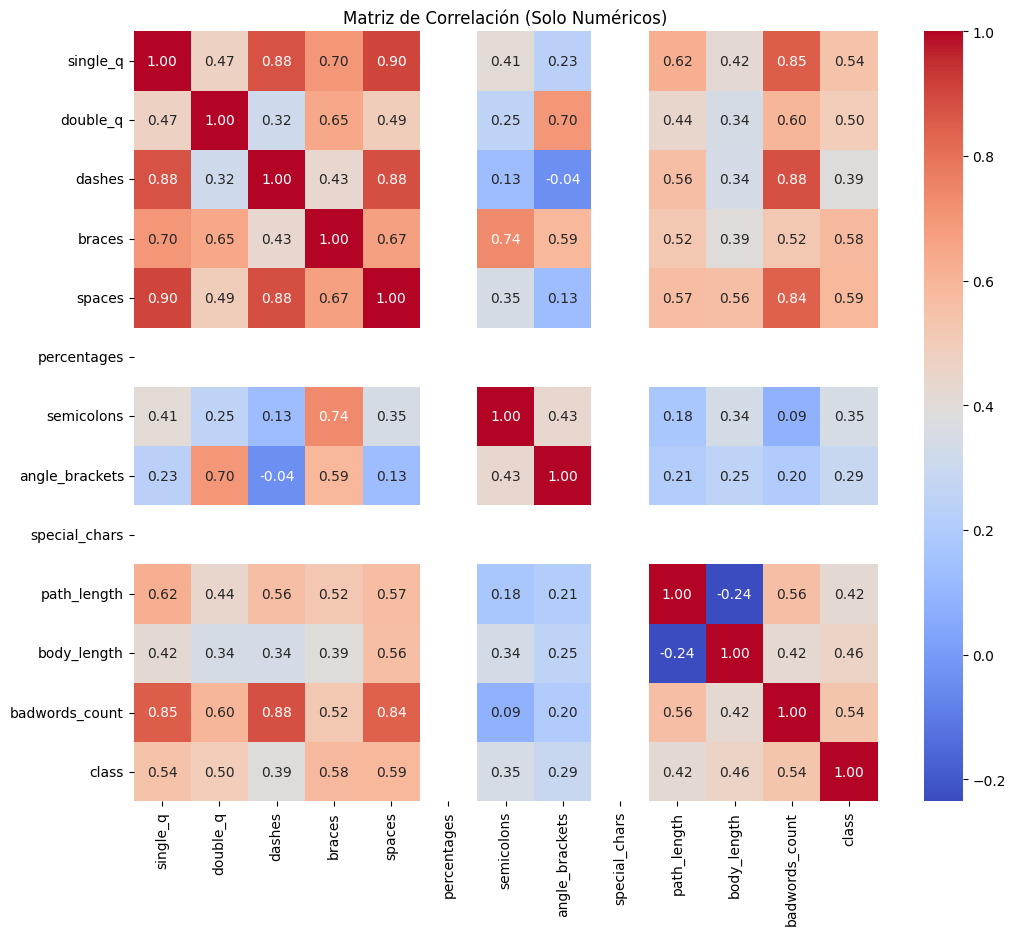

In [15]:
# CMapa de calor a partir de la matriz de correlación
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, mask=correlation_matrix.isnull())
plt.title("Matriz de Correlación (Solo Numéricos)")
plt.show()

Crear nuevas columnas basadas en palabras clave:
- El patrón de expresión regular (keywords) busca las palabras "java", "sleep", "exec" o "system".
- Se utiliza el método .str.count() para contar cuántas veces aparecen estas palabras en cada fila.

Nuevas columnas generadas:
- 'path_keyword_count': Cantidad de palabras clave en la columna 'path'.
- 'body_keyword_count': Cantidad de palabras clave en la columna 'body'.

In [16]:
# --- PREPARACIÓN DEL DATASET ---

from sklearn.preprocessing import LabelEncoder

# Eliminar columnas irrelevantes
irrelevant_columns = ["percentages", "special_chars"]
df = df.drop(columns=irrelevant_columns)

df['body'] = df['body'].fillna("EMPTY") # Imputar valores nulos en 'body' con "EMPTY"

# Crear nuevas columnas basadas en palabras clave en 'path' y 'body'
keywords = r'(java|sleep|exec|system)'
df['path_keyword_count'] = df['path'].str.count(keywords)
df['body_keyword_count'] = df['body'].str.count(keywords)

Se han aplicado todas las transformaciones. En casos method o class nos vamos a asegurar
mediante la técnica de SMOTE nos aseguraremos de equilibrar el peso para los valores minoritarios

In [17]:
df = pd.get_dummies(df, columns=['method'], drop_first=True) # Se convierte 'method' en variable binaria
print(df.head()) # Verificar las transformaciones

                                                path  \
0                                           /doLogin   
1                                      /sendFeedback   
2                                 /admin/clients.xls   
3  /my%20documents/JohnSmith/Bank%20Site%20Docume...   
4  /my%20documents/JohnSmith/Bank%20Site%20Docume...   

                                                body  single_q  double_q  \
0                  uid=ZAP&passw=ZAP&btnSubmit=Login         0         0   
1  cfile=comments.txt&name=ZAP&email_addr=ZAP&sub...         0         0   
2                                              EMPTY         0         0   
3                                              EMPTY         0         0   
4                                              EMPTY         0         0   

   dashes  braces  spaces  semicolons  angle_brackets  path_length  \
0       0       0       0           0               0            8   
1       0       0       7           0               0           13

Aún nos quedan las columnas path y body como categóricas, además para path hay 228 valores únicos
y para body 79, pueden haber datos muy representativos para el análisis por lo que me decido
a volver a discriminar en columnas buscando más palabras relevantes asociadas al tráfico sospechoso,
buscamos en internet cuales pueden ser estas palabras asociadas a tráfico malicioso

In [18]:

#Revisamos que no existen columnas categóricas antes de aplicar SMOTE
columnas_categoricas = df.select_dtypes(include=['object']).columns
print("Columnas categóricas restantes:", columnas_categoricas)

Columnas categóricas restantes: Index(['path', 'body'], dtype='object')


Verificamos que efectivamente se han creado las columnas y que ha extraído valores númericos asociados
a las palabras clave buscadas

In [19]:
# Extracción de palabras clave relacionadas con ataques y creación de columnas numéricas con la información recaudada
# Lista de palabras clave sospechosas
badwords = [
    'sleep', 'uid', 'select', 'waitfor', 'delay', 'system', 'union',
    'order by', 'group by', 'admin', 'drop', 'script', 'exec',
    'ping', 'wget', 'curl', 'nslookup', 'net user', 'whoami',
    'shutdown', 'reboot', '<script>', '</script>', '<iframe>',
    '<img', 'onload=', 'javascript:', 'alert(', 'document.cookie',
    'eval(', 'unescape(', '../', '..\\', '/etc/passwd', '/bin/bash',
    'C:\\Windows\\System32', '(|)', '(&)', '!(|)', '*', '--',
    'or 1=1', ';', 'debug', 'test', 'probe', 'exploit', 'malware',
    'virus', 'attack', 'hacker', 'payload', 'shell', 'ftp', 'bash',
    'powershell', 'chmod'
]


escaped_badwords = [re.escape(word) for word in badwords] # Escapar caracteres especiales en cada palabra clave
badwords_pattern = r'|'.join(escaped_badwords) # Crear el patrón regex uniendo las palabras escapadas

# Aplicar el patrón para contar palabras clave en las columnas 'path' y 'body'
df['path_badwords_count'] = df['path'].str.count(badwords_pattern)
df['body_badwords_count'] = df['body'].str.count(badwords_pattern)
print(df[['path_badwords_count', 'body_badwords_count']].head())

   path_badwords_count  body_badwords_count
0                    0                    1
1                    0                    0
2                    1                    0
3                    0                    0
4                    0                    0


Verificamos que quedan borradas y además se observa que ha encontrado alguna palabra más. Nos aseguramos que el dataset ya es
completamente numérico y susceptible de ser entrenado

In [20]:
# Se procede a eliminar estas dos columnas categóricas
df = df.drop(columns=['body', 'path'])
print("Columnas del dataset después de eliminar 'body' y 'path':", df.columns)

Columnas del dataset después de eliminar 'body' y 'path': Index(['single_q', 'double_q', 'dashes', 'braces', 'spaces', 'semicolons',
       'angle_brackets', 'path_length', 'body_length', 'badwords_count',
       'class', 'path_keyword_count', 'body_keyword_count', 'method_POST',
       'path_badwords_count', 'body_badwords_count'],
      dtype='object')


Hay una correlación moderada con respecto a la variable objetivo "class", por lo que a priori podemos decir que la relación
es positiva para el modelo y es útil, en principio vamos bien...

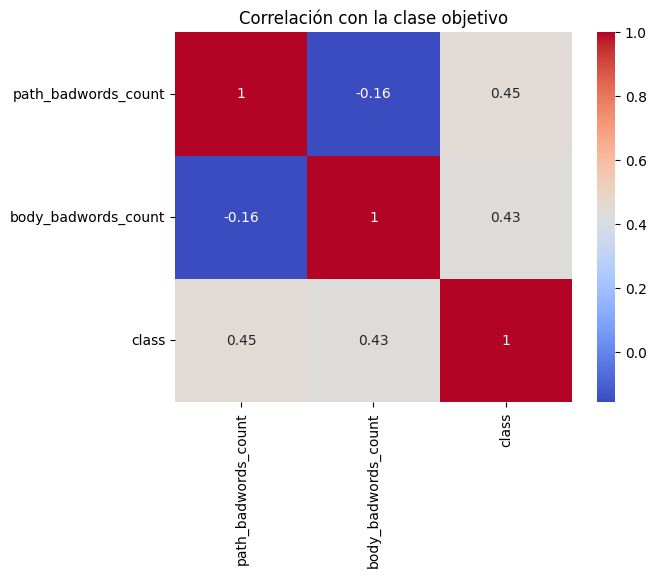

In [21]:

correlation_matrix = df[['path_badwords_count', 'body_badwords_count', 'class']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlación con la clase objetivo')
plt.show()

Se observan muchos outliers en body_lenght y en path_lengt, lo cual es esperado y significativo para el modelo,
se decide no hacer nada con ellos

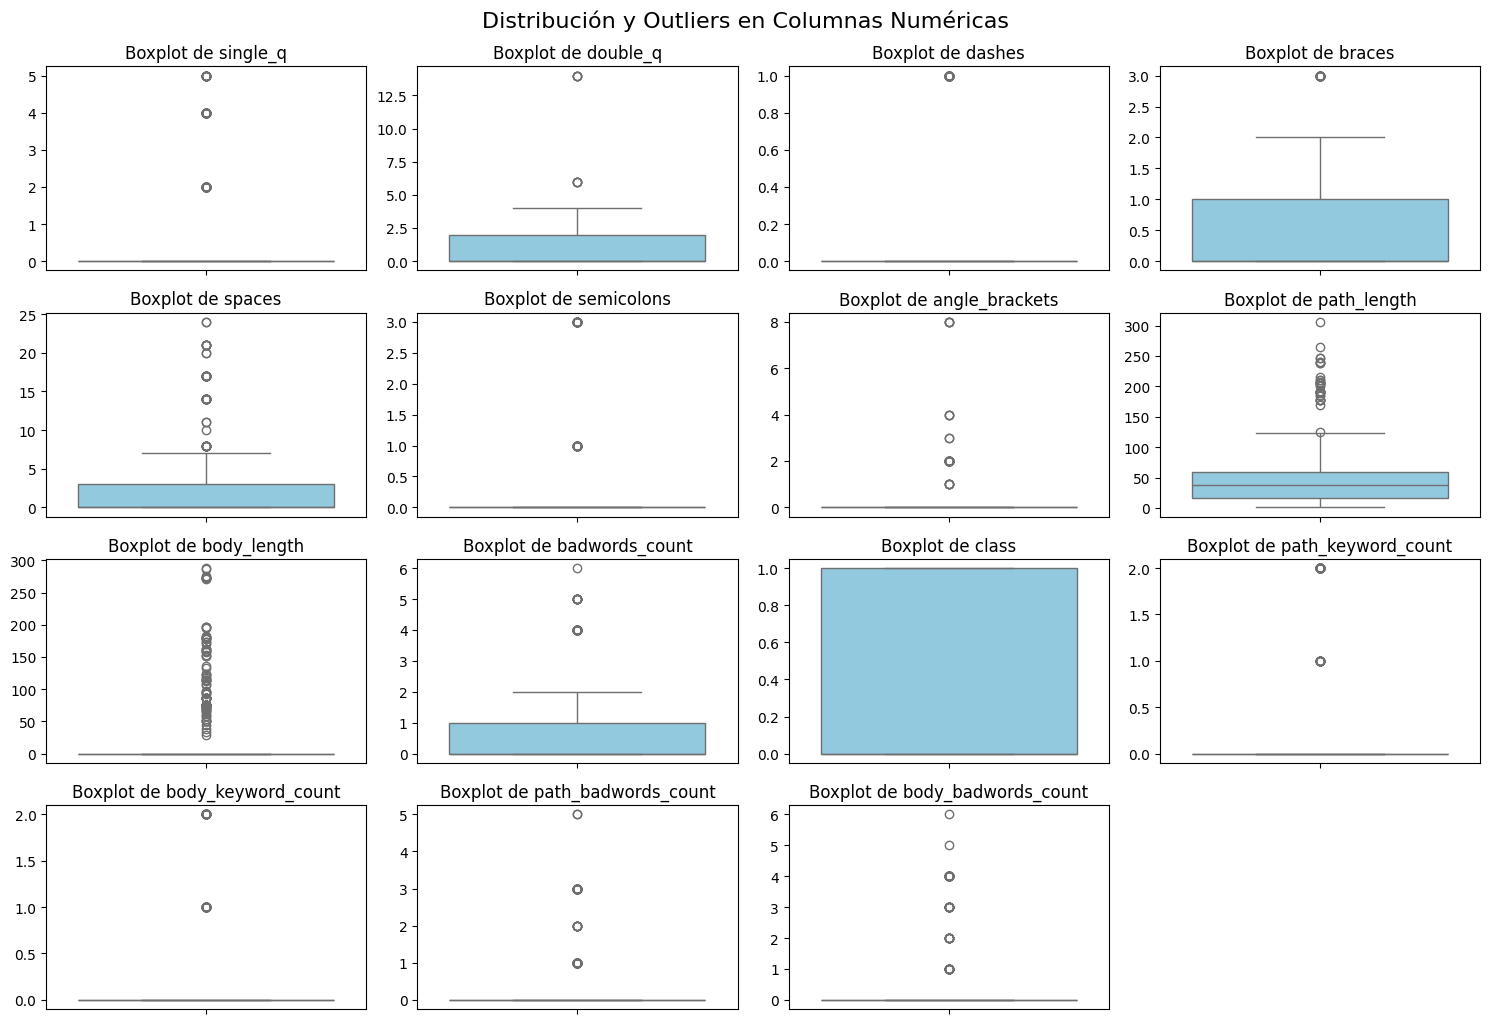

In [22]:

# Verificación de outliers

numeric_cols = df.select_dtypes(include=['number']).columns.tolist() # Seleccionar columnas numéricas actualizadas

# Crear un gráfico de boxplot para cada columna
plt.figure(figsize=(15, 10)) # Configurar tamaño de la figura y subplots
for i, col in enumerate(numeric_cols):
    plt.subplot((len(numeric_cols) // 4) + 1, 4, i + 1)
    sns.boxplot(y=df[col], color='skyblue')
    plt.title(f"Boxplot de {col}")
    plt.ylabel("")

plt.tight_layout()
plt.suptitle("Distribución y Outliers en Columnas Numéricas", fontsize=16, y=1.02)
plt.show()

Vamos a verificar si hay desbalanceo para evitar que los valores minoritarios no tengan peso para el modelo,
en dataSets como este es importante observarlos ya que el trafico malicioso de virus suele ser minoritario con respecto al tráfico normal y por ende dificil detectar

In [31]:
# ---> Ajustamos el desbalanceo aplicando class-weight (alternativa a SMOTE)

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Separamos características (X) y la variable objetivo (y)
X = df.drop(columns=['class'])  # Eliminar la columna objetivo
y = df['class']  # Variable objetivo
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y) # Dividimos en conjunto de entrenamiento y prueba

# Entrenar modelo con class_weight='balanced'
rf_balanced = RandomForestClassifier(random_state=42, class_weight='balanced')
rf_balanced.fit(X_train, y_train)

# Evaluar en el conjunto de prueba
predicciones = rf_balanced.predict(X_test)

# Mostrar reporte de clasificación
print(classification_report(y_test, predicciones))

# Exportamos el dataframe ya procesado para trabajar sobre él
export_path = "/content/sample_data/all_datas_f_CLASS_WEIGHT.csv"  # Ruta donde se guardará el archivo
df.to_csv(export_path, index=False)
print(f"Dataset preprocesado guardado en {export_path}")



              precision    recall  f1-score   support

           0       1.00      0.95      0.97        58
           1       0.94      1.00      0.97        47

    accuracy                           0.97       105
   macro avg       0.97      0.97      0.97       105
weighted avg       0.97      0.97      0.97       105

Dataset preprocesado guardado en /content/sample_data/all_datas_f_CLASS_WEIGHT.csv


Entrenamos y evaluamos:
Random Forest se posiciona como el modelo más robusto al combinar un recall perfecto (100%) con un F1 Score y ROC-AUC
sobresalientes, lo que lo hace ideal para aplicaciones donde evitar falsos negativos (tráfico malicioso no detectado)
es crítico. Naive Bayes y Decision Tree también muestran un excelente rendimiento, siendo alternativas razonables si la
eficiencia computacional o interpretabilidad son prioritarias.XGBoost y Logistic Regression son opciones equilibradas, con métricas sólidas y aplicables en escenarios menos críticos.

Dataset cargado con éxito:
   single_q  double_q  dashes  braces  spaces  semicolons  angle_brackets  \
0         0         0       0       0       0           0               0   
1         0         0       0       0       7           0               0   
2         0         0       0       0       0           0               0   
3         0         0       0       0       3           0               0   
4         0         0       0       0       3           0               0   

   path_length  body_length  badwords_count  class  path_keyword_count  \
0            8           33               1      1                   0   
1           13          124               0      1                   0   
2           18            0               1      1                   0   
3           57            0               0      1                   0   
4           82            0               0      1                   0   

   body_keyword_count  method_POST  path_badwords_count  body_bad

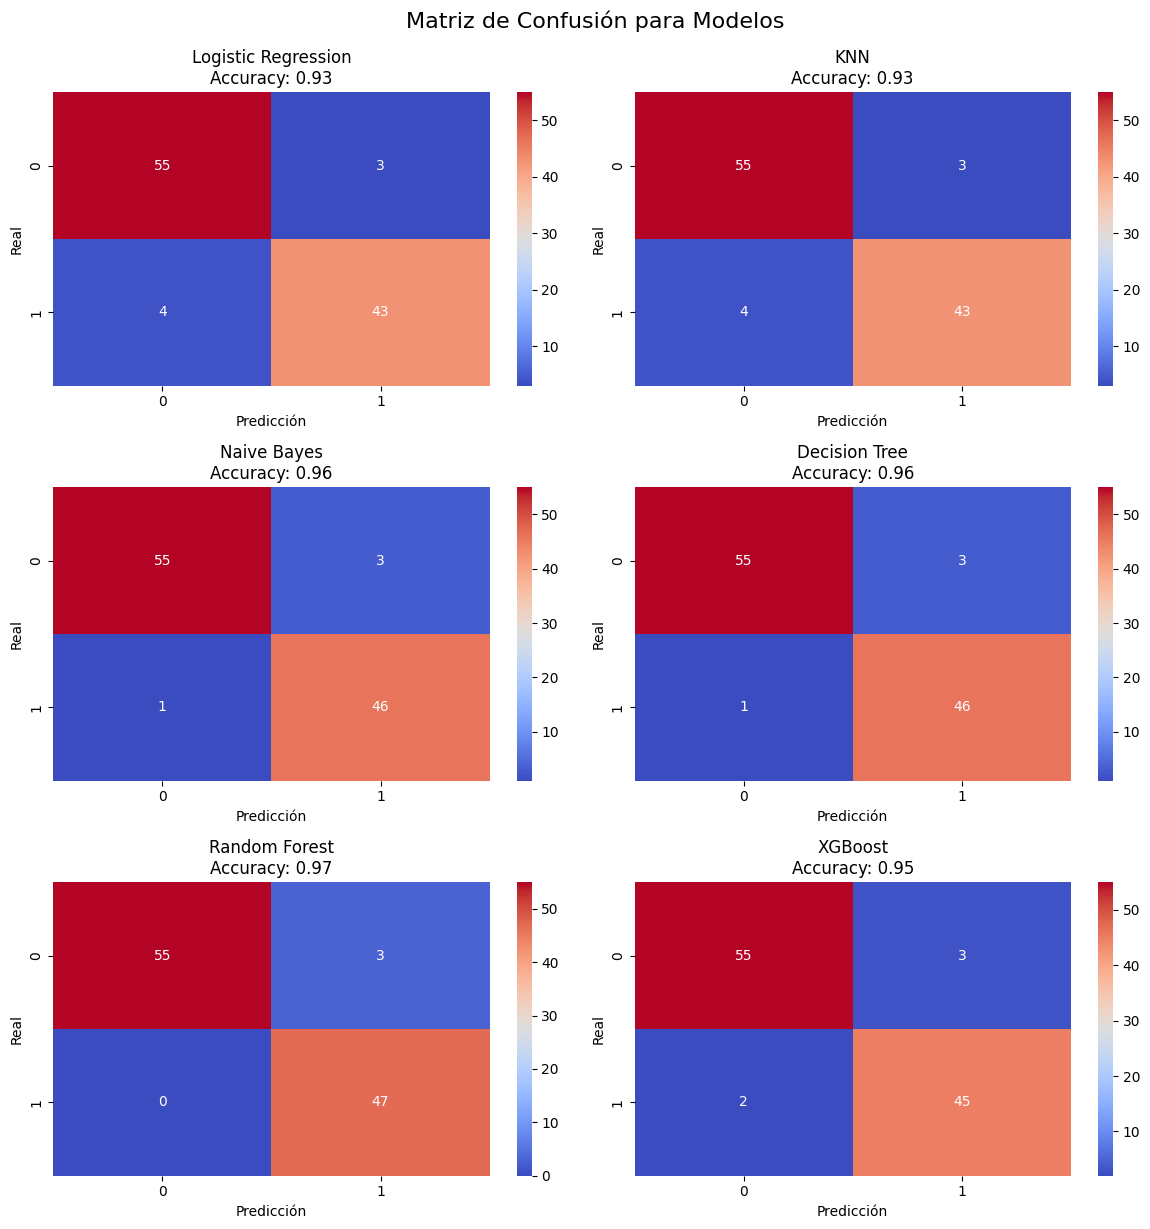

In [33]:

# ---> ENTRENAMIENTO Y EVALUACIÓN

df = pd.read_csv("/content/sample_data/all_datas_f_CLASS_WEIGHT.csv")
print("Dataset cargado con éxito:")
print(df.head())


import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Función para evaluar modelos y generar subplots
def evaluar_modelos_en_ventana(modelos, X_train, y_train, X_test, y_test):
    # Configurar subplots
    num_modelos = len(modelos)
    filas = (num_modelos // 2) + (num_modelos % 2)
    fig, axes = plt.subplots(nrows=filas, ncols=2, figsize=(12, filas * 4))
    axes = axes.flatten()  # Aplanar los ejes para iterar fácilmente

    for i, (nombre, modelo) in enumerate(modelos.items()):
        print(f"Entrenando y evaluando modelo: {nombre}")

        # Entrenar el modelo
        modelo.fit(X_train, y_train)

        # Hacer predicciones
        predicciones = modelo.predict(X_test)

        # Calcular métricas
        accuracy = accuracy_score(y_test, predicciones)
        precision = precision_score(y_test, predicciones)
        recall = recall_score(y_test, predicciones)
        f1 = f1_score(y_test, predicciones)
        roc_auc = roc_auc_score(y_test, modelo.predict_proba(X_test)[:, 1])

        # Mostrar métricas en consola
        print(f"\n--- {nombre} ---")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1:.4f}")
        print(f"ROC-AUC: {roc_auc:.4f}")

        # Graficar la matriz de confusión
        matriz_confusion = confusion_matrix(y_test, predicciones)
        sns.heatmap(matriz_confusion, annot=True, fmt="d", cmap="coolwarm", ax=axes[i])
        axes[i].set_title(f"{nombre}\nAccuracy: {accuracy:.2f}")
        axes[i].set_xlabel("Predicción")
        axes[i].set_ylabel("Real")

    # Ocultar los ejes sobrantes si hay menos modelos que subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    # Ajustar diseño
    plt.tight_layout()
    plt.suptitle("Matriz de Confusión para Modelos", fontsize=16, y=1.02)
    plt.show()

# Modelos a evaluar
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier

import xgboost as xgb

modelos = {
    "Logistic Regression": LogisticRegression(max_iter=100, random_state=42),
    "KNN": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": xgb.XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)
}

# Llamada a la función
evaluar_modelos_en_ventana(modelos, X_train, y_train, X_test, y_test)

1. Naive Bayes obtuvo el mejor rendimiento promedio en validación cruzada (95.41%), mostrando su eficacia en este dataset.
2. XGBoost y KNN también lograron altos desempeños con 94.63% y 94.07% respectivamente, siendo opciones sólidas.
3. Logistic Regression y Random Forest tuvieron resultados aceptables (92.15% y 93.11%), aunque ligeramente por debajo de los mejores modelos.
4. Decision Tree fue el modelo con menor rendimiento (91.01%), probablemente debido a su tendencia al sobreajuste en conjuntos pequeños.
*Nota: Por incompatibilidad del librerías en Colab, se observa que el resultado de la validación se muestra.

In [34]:

# --- 6. VALIDACIÓN CRUZADA ---
print("\n--- VALIDACIÓN CRUZADA ---")
for nombre, modelo in modelos.items():
    scores = cross_val_score(modelo, X, y, cv=5, scoring="accuracy")
    print(f"{nombre} - Accuracy promedio: {scores.mean():.4f}")


--- VALIDACIÓN CRUZADA ---
Logistic Regression - Accuracy promedio: 0.9215
KNN - Accuracy promedio: 0.9407
Naive Bayes - Accuracy promedio: 0.9541
Decision Tree - Accuracy promedio: 0.9101
Random Forest - Accuracy promedio: 0.9311


AttributeError: 'super' object has no attribute '__sklearn_tags__'

Tras haber jugado un poco con la librería Lazypredict, me resulta interesante terminar el análisis
invocándola para comparar los resultados de los modelos estudiados con otros modelos


--- LAZYCLASSIFIER ---


 97%|█████████▋| 31/32 [00:02<00:00,  8.78it/s]

[LightGBM] [Info] Number of positive: 188, number of negative: 229
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000606 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 152
[LightGBM] [Info] Number of data points in the train set: 417, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.450839 -> initscore=-0.197280
[LightGBM] [Info] Start training from score -0.197280
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

100%|██████████| 32/32 [00:03<00:00, 10.16it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
ExtraTreeClassifier                0.98               0.98     0.98      0.98   
RandomForestClassifier             0.97               0.97     0.97      0.97   
BaggingClassifier                  0.96               0.96     0.96      0.96   
DecisionTreeClassifier             0.96               0.96     0.96      0.96   
ExtraTreesClassifier               0.96               0.96     0

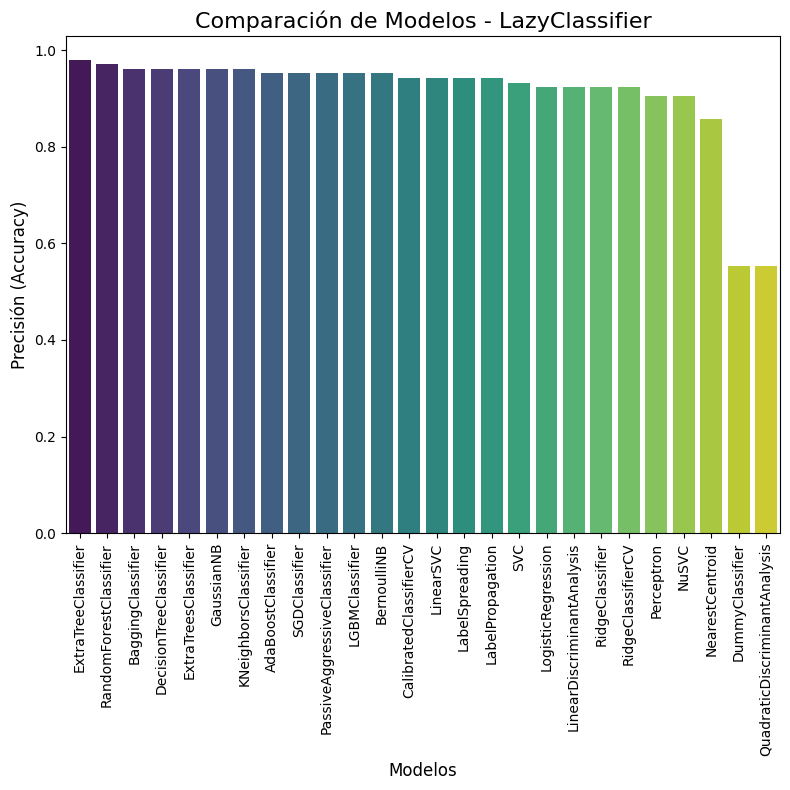

In [35]:
# --- 7. COMPARACIÓN CON LAZYCLASSIFIER ---
print("\n--- LAZYCLASSIFIER ---")
lazy_clf = LazyClassifier(verbose=0, ignore_warnings=True)
models, predictions = lazy_clf.fit(X_train, X_test, y_train, y_test)
print(models)

# Visualizamos los resultados con un gráfico de barras
plt.figure(figsize=(8, 8))  # Aumentamos el tamaño para mejor visibilidad
sns.barplot(x=models.index, y=models["Accuracy"], palette="viridis")
plt.title("Comparación de Modelos - LazyClassifier", fontsize=16)
plt.xlabel("Modelos", fontsize=12)
plt.ylabel("Precisión (Accuracy)", fontsize=12)

# Rotamos las etiquetas del eje X para mayor claridad
plt.xticks(rotation=90, ha="center", fontsize=10)

# Mostramos el gráfico
plt.tight_layout()  # Ajusta automáticamente los elementos para que no se superpongan
plt.show()

El modelo ExtraTree supera en 1 punto al modelo de RamdonForest, por lo que nos decantamos por este modelo en el presente análisis y averiguaremos más sobre ExtraTree en otro análisis.